**<font size="5">Applied Statistics</font>**

<font size="3">MSc in High Performance Computing Engineering, Computer Science and Engineering, Physics Engineering - A.Y. 2024-2025</font>

Prof. Mario Beraha - Dott. Vittorio Torri

---

<font size="4">**Lab 5 - Linear and Quadratic Discriminant Analysis, K-nearest neighbours**</font>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, bartlett, f_oneway, norm
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix

# Linear Discriminant Analysis

## Univariate

Interferon-gamma (IFN-gamma) and interleukin-5 (IL-5) are multifunctional cytokines that regulate immune responses, cell proliferation, and tumour development and progression, which frequently have functionally opposing roles.

Idea: we aim to find a "rule" to classify patients as Group A (the treatment has effect) or Group B (the treatment has no effect)  given the measurements of Inf-g (Interferon gamma) and IL-5 (Interleukin 5).
For this example, we discard the IL-5 variable (which seems to have poor
"discriminative power") and we consider the univariate case with Inf-g only.

### Load and check data

In [3]:
cyto = pd.read_csv("../DatasetsLabs/cytokines.txt", sep=" ")

print(cyto)

# We separate groups A and B:
A_idx = cyto.index[ cyto["group"] == 'A' ]
B_idx = cyto.index[ cyto["group"] == 'B' ]

Infg = cyto["Infg"].values
IL5  = cyto["IL5"].values
groups = cyto["group"].values


         Infg        IL5 group
0   15.000000  12.312595     A
1   23.698101  18.422812     A
2    8.781799   8.501765     A
3   32.211799  -1.371131     A
4   30.838288   7.496666     A
5   12.876335 -15.159156     A
6   12.526771  17.187205     A
7   24.043710  39.919920     A
8   -8.502941   7.099296     B
9    9.176056  -5.047772     B
10   4.857983   5.138093     B
11   2.649528   7.007139     B
12   3.605551  -9.859006     B


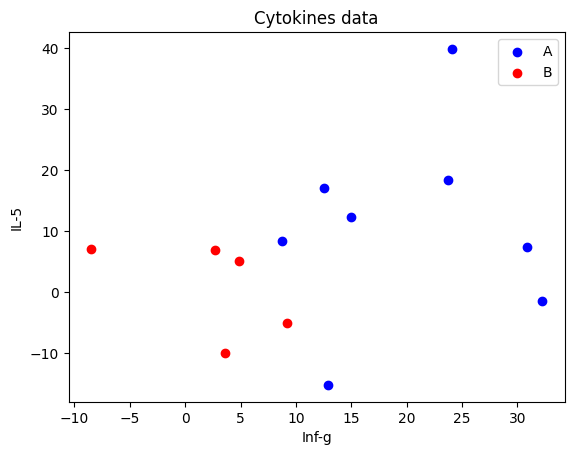

In [4]:
plt.figure()
# Blue for A, Red for B
plt.scatter(Infg[A_idx], IL5[A_idx], color='blue', label='A', marker='o')
plt.scatter(Infg[B_idx], IL5[B_idx], color='red',  label='B', marker='o')
plt.xlabel("Inf-g")
plt.ylabel("IL-5")
plt.legend()
plt.title("Cytokines data")
plt.show()


In [5]:
# Shapiro test for normality of A and B
stat_A, pval_A = shapiro(Infg[A_idx])
stat_B, pval_B = shapiro(Infg[B_idx])
print("Shapiro test group A:", stat_A, pval_A)
print("Shapiro test group B:", stat_B, pval_B)

# Bartlett test for equality of variance
bart_stat, bart_pval = bartlett(Infg[A_idx], Infg[B_idx])
print("Bartlett test: statistic =", bart_stat, "p-value =", bart_pval)

Shapiro test group A: 0.9068374410530935 0.33233011230371007
Shapiro test group B: 0.8754737847978038 0.2893012186768233
Bartlett test: statistic = 0.39982188279368674 p-value = 0.5271812583306359


### Manual implementation of LDA

In [6]:
nA = len(A_idx)
nB = len(B_idx)
n  = nA + nB

PA = nA / n
PB = nB / n

MA = np.mean(Infg[A_idx])
MB = np.mean(Infg[B_idx])

SA = np.var(Infg[A_idx], ddof=1)
SB = np.var(Infg[B_idx], ddof=1)

# Pooled variance estimate
S  = ((nA - 1) * SA + (nB - 1) * SB) / (n - 2)

print(f"Means: M_A={MA:.3f}, M_B={MB:.3f}")
print(f"Pooled var: S={S:.3f}")
print(f"Group prior probabilities: P(A)={PA}, P(B)={PB}")

Means: M_A=19.997, M_B=2.357
Pooled var: S=66.037
Group prior probabilities: P(A)=0.6153846153846154, P(B)=0.38461538461538464


$$ P(y_i|X) = \frac{P(X|y_i)P(y_i)}{P(X)} = \frac{P(X|y_i)P(y_i)}{\sum_{j}P(X|y_j)P(y_j)}$$

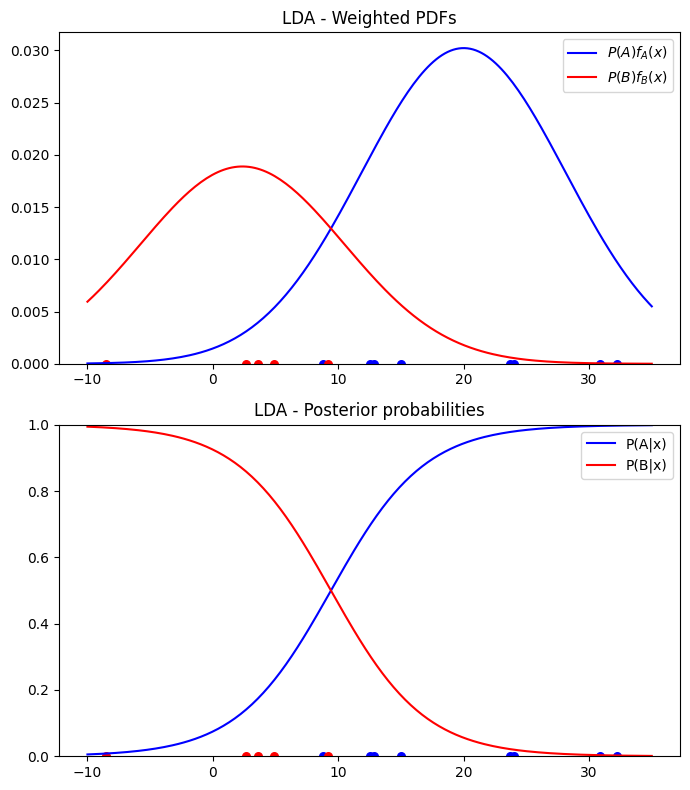

In [7]:
xgrid = np.linspace(-10, 35, 200)

# pdf for group A
pdfA = norm.pdf(xgrid, loc=MA, scale=np.sqrt(S))
# pdf for group B
pdfB = norm.pdf(xgrid, loc=MB, scale=np.sqrt(S))

plt.figure(figsize=(7,8))

# Top plot: PA * fA(x) and PB * fB(x)
plt.subplot(2,1,1)
plt.plot(xgrid, PA*pdfA, color='blue', label=r'$P(A)f_A(x)$')
plt.plot(xgrid, PB*pdfB, color='red',  label=r'$P(B)f_B(x)$')
plt.scatter(Infg[A_idx], np.zeros(nA), color='blue', s=30)
plt.scatter(Infg[B_idx], np.zeros(nB), color='red',  s=30)
plt.ylim(0, None)
plt.title("LDA - Weighted PDFs")
plt.legend()

# Bottom plot: Posterior probabilities
postA = PA*pdfA / (PA*pdfA + PB*pdfB)
postB = PB*pdfB / (PA*pdfA + PB*pdfB)

plt.subplot(2,1,2)
plt.plot(xgrid, postA, color='blue', label='P(A|x)')
plt.plot(xgrid, postB, color='red',  label='P(B|x)')
plt.scatter(Infg[A_idx], np.zeros(nA), color='blue', s=30)
plt.scatter(Infg[B_idx], np.zeros(nB), color='red',  s=30)
plt.ylim(0,1)
plt.title("LDA - Posterior probabilities")
plt.legend()
plt.tight_layout()
plt.show()


### LDA via scikit-learn

Posterior at x=0: [0.07476761 0.92523239]
Class assigned at x=0: ['B']


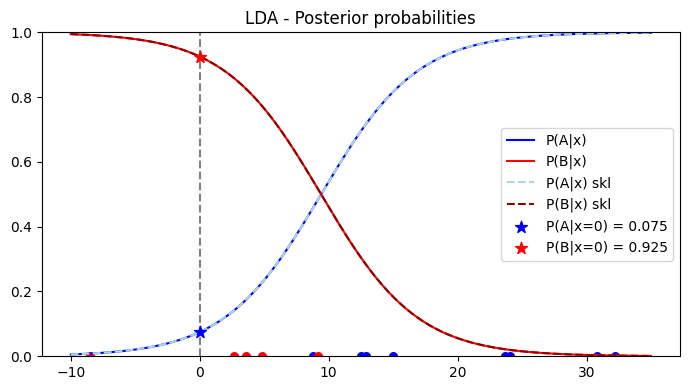

In [8]:
X = Infg.reshape(-1, 1)
y = groups

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# Posterior probability for x=0:
x0_val = 0.0
posterior0 = lda.predict_proba([[x0_val]])[0]
postA_x0, postB_x0 = posterior0  # two classes (A, B)
print("Posterior at x=0:", posterior0)
print("Class assigned at x=0:", lda.predict([[x0_val]]))

# Posterior for a grid of x
xgrid = np.linspace(-10, 35, 200).reshape(-1, 1)
post_grid = lda.predict_proba(xgrid)  # columns: prob of A, prob of B
postA_skl = post_grid[:,0]
postB_skl = post_grid[:,1]

plt.figure(figsize=(7,4))
plt.plot(xgrid, postA, color='blue', label='P(A|x)')
plt.plot(xgrid, postB, color='red',  label='P(B|x)')
plt.plot(xgrid, postA_skl, '--', color='lightblue', label='P(A|x) skl')
plt.plot(xgrid, postB_skl, '--', color='darkred',  label='P(B|x) skl')
plt.scatter(Infg[A_idx], np.zeros(nA), color='blue', s=30)
plt.scatter(Infg[B_idx], np.zeros(nB), color='red',  s=30)
# Highlight the value at x=0:
plt.axvline(x=x0_val, color='gray', linestyle='--')
# 2. Markers for the two posterior values at x=0
plt.scatter([x0_val], [postA_x0], s=80, color='blue',  marker='*', zorder=5,
            label='P(A|x=0) = {:.3f}'.format(postA_x0))
plt.scatter([x0_val], [postB_x0], s=80, color='red',   marker='*', zorder=5,
            label='P(B|x=0) = {:.3f}'.format(postB_x0))
plt.ylim(0,1)
plt.title("LDA - Posterior probabilities")
plt.legend()
plt.tight_layout()
plt.show()

Explicitly set the priors

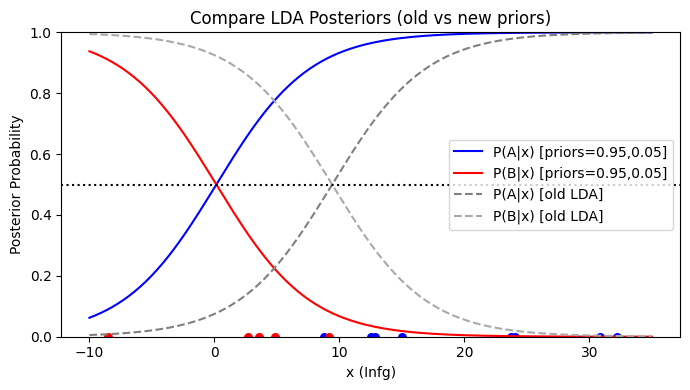

In [9]:
lda_1 = LinearDiscriminantAnalysis(priors=[0.95, 0.05])
lda_1.fit(X, y)

# Posterior on the same grid:
post_grid_1 = lda_1.predict_proba(xgrid)
postA_1 = post_grid_1[:, 0]
postB_1 = post_grid_1[:, 1]

plt.figure(figsize=(7, 4))

plt.plot(xgrid, postA_1, color='blue', label='P(A|x) [priors=0.95,0.05]')
plt.plot(xgrid, postB_1, color='red',  label='P(B|x) [priors=0.95,0.05]')

plt.plot(xgrid, postA_skl, '--', color='gray', label='P(A|x) [old LDA]')
plt.plot(xgrid, postB_skl, '--', color='darkgray', label='P(B|x) [old LDA]')

# Add horizontal line at 0.5
plt.axhline(y=0.5, color='black', linestyle=':')

# Add the points on x-axis for groups A and B
plt.scatter(Infg[A_idx], np.zeros(len(A_idx)), color='blue',  s=30)
plt.scatter(Infg[B_idx], np.zeros(len(B_idx)), color='red',   s=30)

plt.ylim(0, 1)
plt.xlabel("x (Infg)")
plt.ylabel("Posterior Probability")
plt.title("Compare LDA Posteriors (old vs new priors)")
plt.legend()
plt.tight_layout()
plt.show()

## Multivariate

### Iris

Considering only the first two variables of the iris datasets (Sepal Length and Sepal Width)

p = 2 # num variables

g = 3 # num groups

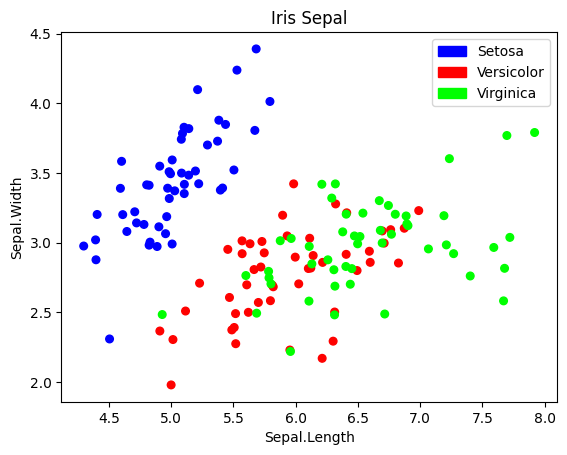

In [10]:
from sklearn.datasets import load_iris
import matplotlib.patches as mpatches

iris_data = load_iris()
X_iris = iris_data.data[:, :2]  # only Sepal.Length, Sepal.Width
y_iris = iris_data.target       # 0, 1, 2 for setosa, versicolor, virginica
species_names = iris_data.target_names

# We'll add small jitter
rng = np.random.RandomState(1)
X_iris = X_iris + rng.normal(scale=0.025, size=X_iris.shape)

plt.figure()
plt.scatter(X_iris[:,0], X_iris[:,1], c=y_iris, cmap='brg', s=30)

handles = [
    mpatches.Patch(color=plt.get_cmap("brg",3)(0), label='Setosa'),
    mpatches.Patch(color=plt.get_cmap("brg",3)(1), label='Versicolor'),
    mpatches.Patch(color=plt.get_cmap("brg",3)(2), label='Virginica')
]
plt.legend(handles=handles, loc='upper right')

plt.title("Iris Sepal")
plt.xlabel("Sepal.Length")
plt.ylabel("Sepal.Width")
plt.show()

In [11]:
lda_iris = LinearDiscriminantAnalysis()
lda_iris.fit(X_iris, y_iris)

print("Coefficients of linear discriminants:\n", lda_iris.coef_)
print("Intercepts:\n", lda_iris.intercept_)

Coefficients of linear discriminants:
 [[-5.94780454  7.87961702]
 [ 1.72106802 -3.82726215]
 [ 4.22673652 -4.05235487]]
Intercepts:
 [  5.63227073  -0.09185336 -15.14199104]


In [12]:
y_pred = lda_iris.predict(X_iris)
conf_mat = confusion_matrix(y_iris, y_pred)
print(conf_mat)

[[49  1  0]
 [ 0 35 15]
 [ 0 15 35]]


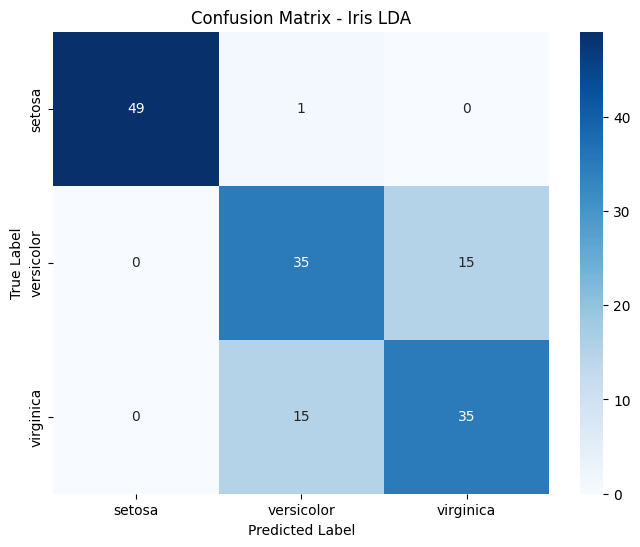

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=species_names, yticklabels=species_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Iris LDA")
plt.show()


In [15]:
# APER (apparent error rate - proportion of misclassified samples)
# NB: this formula is correct if the proportions are estimated via empirical frequencies
# Otherwise it is sum of P(error|group g) * P(group g) = sum{ # errors_for_group_g * prior_prob[g]}
n_samples = len(y_iris)
misclassified = (y_pred != y_iris).sum()
APER = misclassified / n_samples
print("APER =", APER)

APER = 0.20666666666666667


In [16]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_iris, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7933333333333333


Let's plot the decision boundary identified by LDA

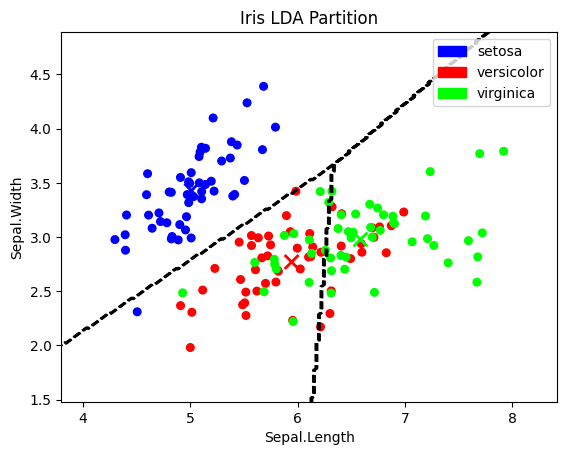

In [17]:
def plot_lda_partition(model, X, y, class_labels=None, title="LDA Partition", xtitle="Sepal.Length", ytitle="Sepal.Width"):
  x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
  y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
  grid_points = np.c_[xx.ravel(), yy.ravel()]

  unique_classes = np.unique(y)
  n_classes = len(unique_classes)
  cmap = plt.get_cmap("brg", n_classes)

  class_pred = model.predict(grid_points)

  plt.figure()
  plt.scatter(X[:,0], X[:,1], c=y, cmap='brg', s=30)
  plt.title("Iris LDA Partition")
  # Now let's draw boundaries where the predicted class changes:
  class_pred_matrix = class_pred.reshape(xx.shape)
  # We'll plot the contour lines between classes:
  # e.g., any place that transitions from class i to j is a boundary.
  plt.contour(xx, yy, class_pred_matrix,
              colors='k', linestyles='--')

  # Mark class means (model.means_ shape: [n_classes, n_features])
  means = model.means_
  plt.scatter(means[:,0], means[:,1], marker='x',
              c=range(len(means)), cmap='brg', s=100, linewidths=2)

  if class_labels is None:
      class_labels = [f"Class {cls}" for cls in unique_classes]  # Default labels if not provided

  handles = [mpatches.Patch(color=cmap(i), label=class_labels[i]) for i in range(n_classes)]
  plt.legend(handles=handles, loc='upper right')

  plt.xlabel(xtitle)
  plt.ylabel(ytitle)
  plt.show()

plot_lda_partition(lda_iris, X_iris, y_iris, class_labels=species_names, title="Iris LDA Partition")


# Quadratic Discriminant Analysis

## Iris

In [ ]:
# fit a Quadratic Discriminant Analysis model from scikit learn, compute the APER and the confusion matrix

In [18]:
qda_iris = QuadraticDiscriminantAnalysis()
qda_iris.fit(X_iris, y_iris)

,priors,None
,reg_param,0.0
,store_covariance,False
,tol,0.0001


In [19]:
y_pred_qda = qda_iris.predict(X_iris)
conf_mat_qda = pd.crosstab(pd.Series(y_iris, name='True'),
                           pd.Series(y_pred_qda, name='Predicted'))
print(conf_mat_qda)

APER_q = (y_pred_qda != y_iris).sum() / len(y_iris)
print("APER QDA =", APER_q)

Predicted   0   1   2
True                 
0          49   1   0
1           0  37  13
2           0  16  34
APER QDA = 0.2


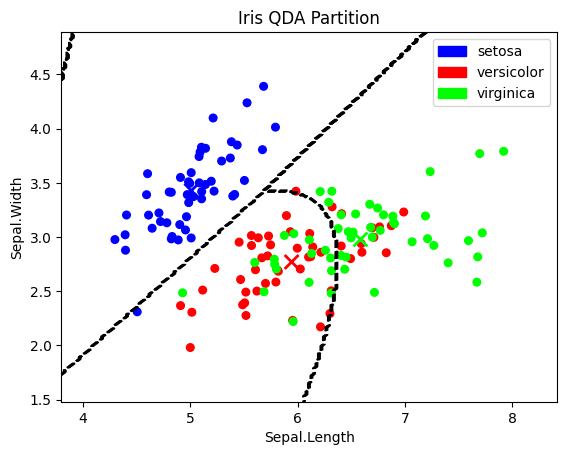

In [20]:
def plot_qda_partition(model, X, y, class_labels=None, title="QDA Partition", cmap=None, xtitle="Sepal.Length", ytitle="Sepal.Width"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    class_pred = model.predict(grid_points)
    if isinstance(class_pred[0], str):
      class_pred = np.array([np.where(class_labels == i) for i in class_pred])
    class_pred_matrix = class_pred.reshape(xx.shape)

    unique_classes = np.unique(y)
    n_classes = len(unique_classes)

    cmap = plt.get_cmap("brg", n_classes)

    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, s=30)
    plt.title(title)
    plt.contour(xx, yy, class_pred_matrix,
                colors='k', linestyles='--')

    # Mark class means
    means = model.means_
    plt.scatter(means[:,0], means[:,1], marker='x',
                c=range(len(means)), cmap=cmap, s=100, linewidths=2)

    if class_labels is None:
        class_labels = [f"Class {cls}" for cls in unique_classes]  # Default labels if not provided

    handles = [mpatches.Patch(color=cmap(i), label=class_labels[i]) for i in range(n_classes)]
    plt.legend(handles=handles, loc='upper right')

    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.show()

plot_qda_partition(qda_iris, X_iris, y_iris, class_labels=species_names, title="Iris QDA Partition")


## Cost-sensitive classification (Banknotes example)

The vending machines of the Exxon fuel contain optical detectors able
to measure the size of the banknotes inserted. Knowing that 0.1% of the
10\$ banknotes in circulation are counterfeit, Exxon would like to implement a
software to identify false 10$ banknotes, as to minimize the economic losses.
Assuming that:
  - both the populations of real and false banknotes follow a normal distribution (with different mean and covariance matrices);
  
  - accepting a false banknote leads to an economic loss of 10$;

  - rejecting a true banknote brings a economic loss quantifiable in 5 cents;

 satisfy the following requests of the Exxon:

 a) build an appropriate classifier, estimating the unknown parameters starting from the two datasets moneytrue.txt and moneyfalse.txt, containing data about 100 true banknotes and 100 counterfeit banknotes (in mm). Qualitatively show the two classification regions in a graph;

 b) calculate the APER of the classifier and, based on the APER, estimate the expected economic damage of the classifier;

 c) what is the estimated probability that the first 10$ banknote inserted in the machine is rejected?

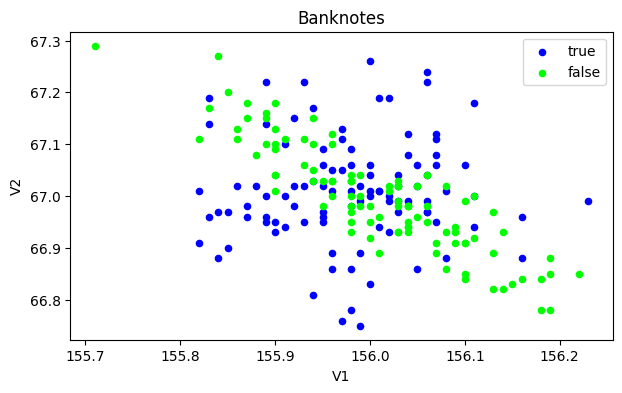

In [22]:
true_df  = pd.read_table("../DatasetsLabs/moneytrue.txt", sep=" ")   # columns e.g. V1, V2
false_df = pd.read_table("../DatasetsLabs/moneyfalse.txt", sep=" ")  # columns e.g. V1, V2

true_data  = true_df[["V1","V2"]].values
false_data = false_df[["V1","V2"]].values

banknotes = np.vstack([true_data, false_data])
vf = np.array(["true"]*len(true_data) + ["false"]*len(false_data), dtype=object)

plt.figure(figsize=(7,4))
plt.scatter(true_data[:,0],  true_data[:,1], color=(0.0, 0.0, 1.0, 1.0),  label='true', s=20)
plt.scatter(false_data[:,0], false_data[:,1], color=(0.0, 1.0, 0.0, 1.0), label='false', s=20)
plt.xlabel("V1")
plt.ylabel("V2")
plt.title("Banknotes")
plt.legend()
plt.show()

Priori probabilities determine the importance of a class. If misclassifying False as True is very costly, we need to increase the prior probability of False:

$$
\pi_{False}' = \frac{c_{TF}\cdot\pi_{False}}{c_{TF}\cdot\pi_{False} + c_{FT}\cdot\pi_{True}}
$$

 a) build an appropriate classifier, estimating the unknown parameters starting from the two datasets moneytrue.txt and moneyfalse.txt, containing data about 100 true banknotes and 100 counterfeit banknotes (in mm). Qualitatively show the two classification regions in a graph;

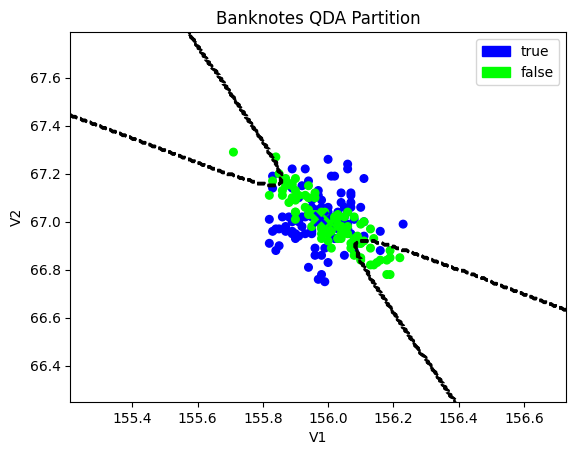

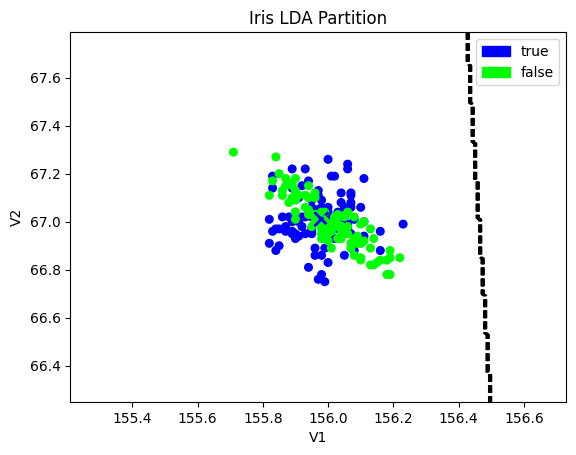

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

c_tf = 10    # cost of accepting a false banknote
c_ft = 0.05  # cost of rejecting a true banknote
pf   = 0.001
pt   = 1 - pf

# Adjusted priors:
den = c_tf*pf + c_ft*pt # normalization factor to keep them sum to 1
p_true_c = pt*c_ft / den
p_false_c = pf*c_tf / den
prior_c = [p_true_c, p_false_c]

desired_order = ["true", "false"]  # the order MUST be consisted with the order of the priors!
y_encoded = np.array([desired_order.index(label) for label in vf])

qda_bank = QuadraticDiscriminantAnalysis(priors=prior_c)
qda_bank.fit(banknotes, y_encoded)

lda_bank = LinearDiscriminantAnalysis(priors=prior_c)
lda_bank.fit(banknotes, y_encoded)


plot_qda_partition(qda_bank, banknotes, y_encoded, class_labels=desired_order, title="Banknotes QDA Partition", xtitle="V1", ytitle="V2")
plot_lda_partition(lda_bank, banknotes, y_encoded, class_labels=desired_order, title="Banknotes LDA Partition", xtitle="V1", ytitle="V2")

b) calculate the APER of the classifier and, based on the APER, estimate the expected economic damage of the classifier;

In [24]:
y_pred = qda_bank.predict(banknotes)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

tp, fn, fp, tn = conf_matrix.ravel()  # Extract False Positives (FP) and False Negatives (FN)

## NB: be aware that here we have the TRUE as the first class, but it is more common to have viceversa

# APER Calculation using extracted FP and FN values
# APER = P(true) * P(misclassified | true) + P(false) * P(misclassified | false)
aper = p_true_c * (fn / (tp + fn)) + p_false_c * (fp / (fp + tn))

print("\nApparent Error Rate (APER): {:.4f}".format(aper))

Confusion Matrix:
[[98  2]
 [80 20]]

Apparent Error Rate (APER): 0.1501


c) what is the estimated probability that the first 10$ banknote inserted in the machine is rejected?

In [25]:
# P[rejected] = P[rejected | true]P[true] + P[rejected | false]P[false]

(fn / (fn+ tp)) * pt + (tn / (tn + fp)) * pf

np.float64(0.02018)

# Fisher Discriminant Analysis

LDA can also be used to project the data into a lower dimensional space, which maximizes the separability between the classes

In [26]:
from sklearn.metrics import confusion_matrix

iris_data = load_iris()
X_iris = iris_data.data
X_iris.shape
X = X_iris
y = y_iris

# Apply Fisher's Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)  # Transform data into canonical coordinates

X_lda.shape, X_iris.shape

((150, 2), (150, 4))

In [27]:
# Compute the confusion matrix for model performance
y_pred = lda.predict(X)
conf_matrix = confusion_matrix(y, y_pred)
APER = 1 - np.trace(conf_matrix) / np.sum(conf_matrix)

print("Misclassification Rate (APER):", APER)
print("Confusion Matrix:\n", conf_matrix)

Misclassification Rate (APER): 0.020000000000000018
Confusion Matrix:
 [[50  0  0]
 [ 0 48  2]
 [ 0  1 49]]


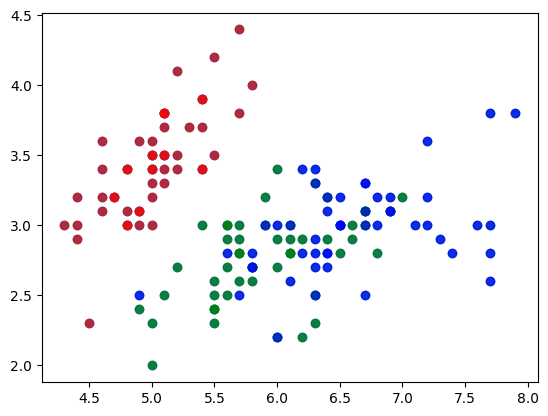

In [31]:
#applying fisher
plt.scatter(X_iris[:, 0], X_iris[:, 1])
X_iris_new = X_iris[0:, :2]
fisher = LinearDiscriminantAnalysis(n_components=2)
fisher.fit(X_iris_new, y_iris)
X_new = fisher.transform(X_iris_new)
#plt.scatter(X_new[:,0], X_new[:,1], c='red')

predictions=fisher.predict(X_iris_new)
predictions

color_species = ['red', 'green', 'blue']

for i, color in zip(range(3), color_species):
    plt.scatter(X_iris_new[y == i, 0], X_iris_new[y == i, 1], c=color, alpha=0.6)


How to classify a new observation in [5.85, 2.90]?

New observation classified as: versicolor


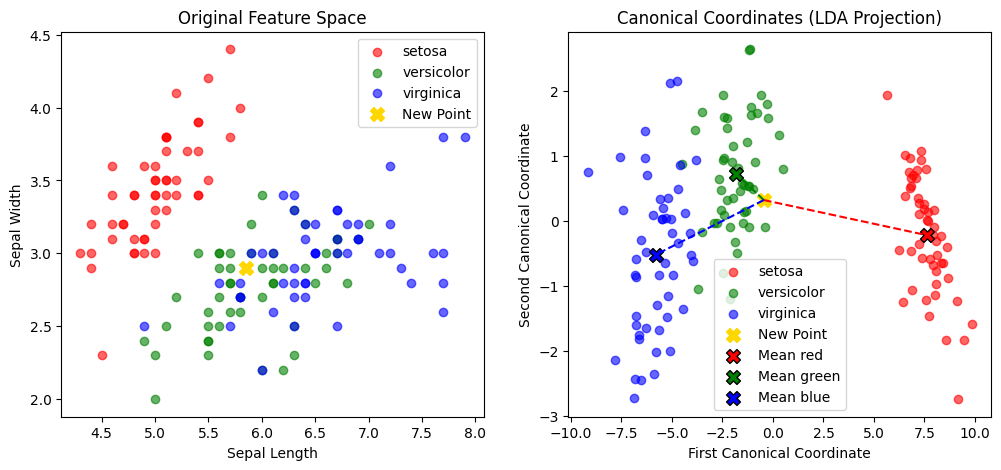

In [33]:
x_new = np.array([[5.85, 2.90]])  # New observation
cc_new = fisher.transform(x_new)  # Project into Fisher’s space
assigned_class = fisher.predict(x_new)
print("New observation classified as:", species_names[assigned_class[0]])

color_species = ['red', 'green', 'blue']

# Compute class means in LDA space
class_means_lda = lda.transform(lda.means_)  # Get means in LDA space

# Plot LDA Results with Connection Lines to Class Centers
def plot_fisher_score_with_connections():
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Original Coordinate Space
    for i, color in zip(range(3), color_species):
        ax[0].scatter(X[y == i, 0], X[y == i, 1], c=color, label=species_names[i], alpha=0.6)

    ax[0].scatter(x_new[0, 0], x_new[0, 1], c='gold', marker='X', s=100, label="New Point")
    ax[0].set_xlabel("Sepal Length")
    ax[0].set_ylabel("Sepal Width")
    ax[0].set_title("Original Feature Space")
    ax[0].legend()

    # Canonical Coordinate Space (LDA Projection)
    for i, color in zip(range(3), color_species):
        ax[1].scatter(X_lda[y == i, 0], X_lda[y == i, 1], c=color, label=species_names[i], alpha=0.6)

    ax[1].scatter(cc_new[0, 0], cc_new[0, 1], c='gold', marker='X', s=100, label="New Point")

    # Connect new observation to class means
    for mean, color in zip(class_means_lda, color_species):
        ax[1].scatter(mean[0], mean[1], c=color, marker="X", s=100, edgecolors="black", label=f"Mean {color}")
        ax[1].plot([cc_new[0, 0], mean[0]], [cc_new[0, 1], mean[1]], color=color, linestyle="dashed")

    ax[1].set_xlabel("First Canonical Coordinate")
    ax[1].set_ylabel("Second Canonical Coordinate")
    ax[1].set_title("Canonical Coordinates (LDA Projection)")
    ax[1].legend()

    plt.show()

plot_fisher_score_with_connections()


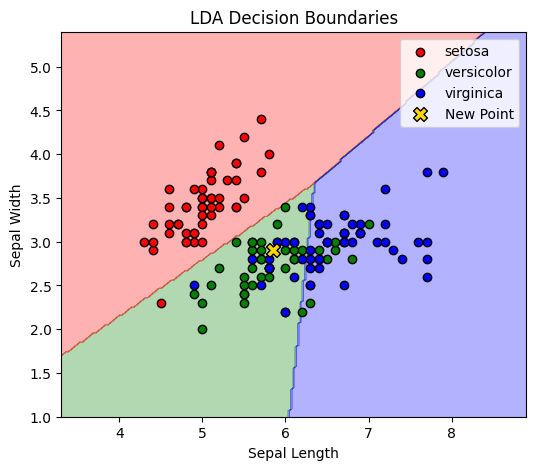

In [35]:
from matplotlib.colors import ListedColormap

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                      np.linspace(y_min, y_max, 200))

# Predict on the grid
Z = fisher.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(color_species))

for i, color in zip(range(3), color_species):
    plt.scatter(X[y == i, 0], X[y == i, 1], c=color, label=species_names[i], edgecolors='k')

plt.scatter(x_new[0, 0], x_new[0, 1], c='gold', marker='X', s=100, label="New Point", edgecolors='black')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("LDA Decision Boundaries")
plt.legend()
plt.show()

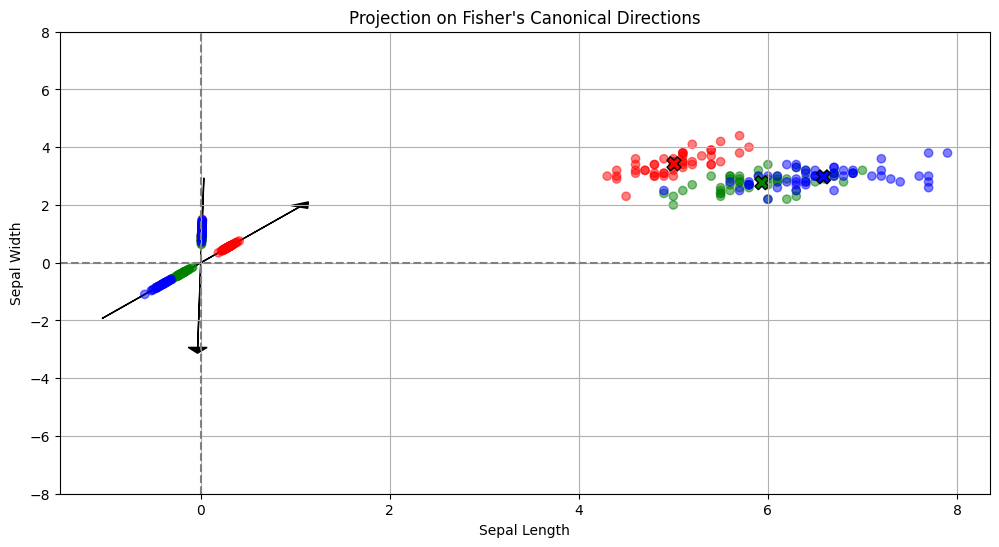

In [36]:
X_lda = lda.fit_transform(X_iris, y_iris)  # Canonical coordinates of data

# Fisher directions (discriminant vectors)
a1, a2 = lda.scalings_[:, 0], lda.scalings_[:, 1]

# Normalize Fisher directions for visualization
a1 /= np.linalg.norm(a1)
a2 /= np.linalg.norm(a2)

# Compute projections onto Fisher directions in the original space
proj_a1 = np.outer(X_iris @ a1, a1) / np.sum(a1 ** 2)
proj_a2 = np.outer(X_iris @ a2, a2) / np.sum(a2 ** 2)

class_means = lda.means_  # Means in original space

color_species = np.array(color_species)

# Plot: Projection on Canonical Directions (Original Space)**
plt.figure(figsize=(12, 6))
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=color_species[y], alpha=0.5, label="Data")
plt.scatter(class_means[:, 0], class_means[:, 1], c=color_species, marker="X", s=100, edgecolors="black", label="Class Means")

# Scale factor for better visibility
t = 5

# Arrows for Fisher directions
plt.arrow(-t * a1[0], -t * a1[1], 2 * t * a1[0], 2 * t * a1[1], head_width=0.2, head_length=0.2, fc='black', ec='black', label="a1 (First Canonical Direction)")
plt.arrow(-t * a2[0], -t * a2[1], 2 * t * a2[0], 2 * t * a2[1], head_width=0.2, head_length=0.2, fc='black', ec='black', label="a2 (Second Canonical Direction)")

# Add dashed lines for original axes
plt.axhline(0, color='gray', linestyle='dashed')
plt.axvline(0, color='gray', linestyle='dashed')

# Projection of points onto Fisher's directions
plt.scatter(proj_a1[:, 0], proj_a1[:, 1], c=color_species[y], alpha=0.5)
plt.scatter(proj_a2[:, 0], proj_a2[:, 1], c=color_species[y], alpha=0.5)

# Labels
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Projection on Fisher's Canonical Directions")
plt.grid(True)
plt.ylim(-8,8)
plt.show()

In [37]:
# Compute the angle between a1 and a2
dot_product = np.dot(a1, a2)
angle_radians = np.arccos(dot_product)  # Angle in radians
angle_degrees = np.degrees(angle_radians)  # Convert to degrees

angle_degrees

np.float64(79.8377504537802)

Let's compare the projection on LDA axes with the one on PCA axes

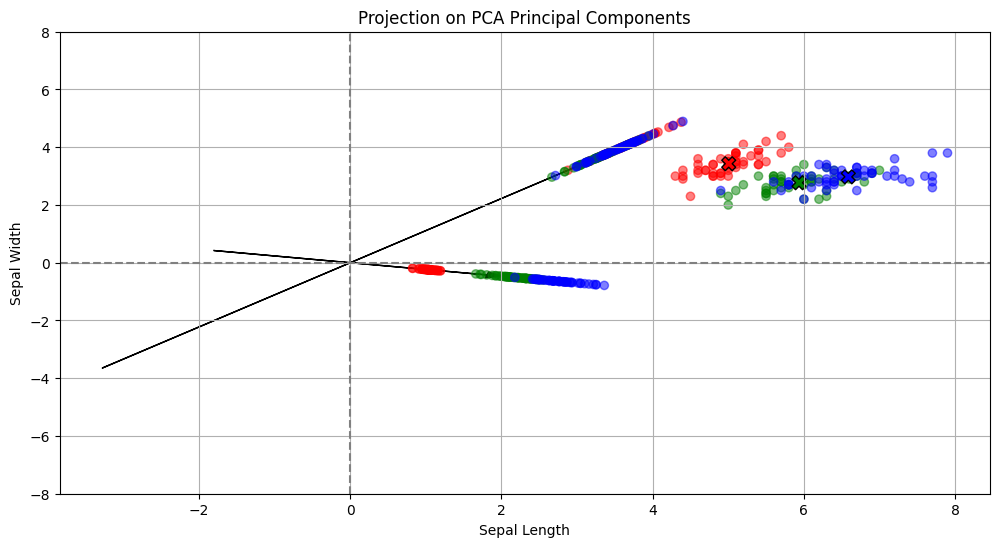

In [38]:
# Perform PCA on the original data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_iris)  # PCA-transformed coordinates

pca1, pca2 = pca.components_

# Normalize PCA directions for visualization
pca1 /= np.linalg.norm(pca1)
pca2 /= np.linalg.norm(pca2)

# Compute projections onto PCA directions in the original space
proj_pca1 = np.outer(X_iris @ pca1, pca1) / np.sum(pca1 ** 2)
proj_pca2 = np.outer(X_iris @ pca2, pca2) / np.sum(pca2 ** 2)

# Compute class means in original space
class_means_pca = np.array([X_iris[y_iris == i].mean(axis=0) for i in range(3)])

# Plot: Projection on PCA Directions (Original Space)
plt.figure(figsize=(12, 6))
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=color_species[y_iris], alpha=0.5, label="Data")
plt.scatter(class_means_pca[:, 0], class_means_pca[:, 1], c=color_species, marker="X", s=100, edgecolors="black", label="Class Means")

# Scale factor for better visibility
t = 5

# Arrows for PCA directions
plt.arrow(-t * pca1[0], -t * pca1[1], 2 * t * pca1[0], 2 * t * pca1[1], head_width=0.2, head_length=0.2, fc='black', ec='black', label="PC1 (First Principal Component)")
plt.arrow(-t * pca2[0], -t * pca2[1], 2 * t * pca2[0], 2 * t * pca2[1], head_width=0.2, head_length=0.2, fc='black', ec='black', label="PC2 (Second Principal Component)")

# Add dashed lines for original axes
plt.axhline(0, color='gray', linestyle='dashed')
plt.axvline(0, color='gray', linestyle='dashed')

# Projection of points onto PCA directions
plt.scatter(proj_pca1[:, 0], proj_pca1[:, 1], c=color_species[y_iris], alpha=0.5)
plt.scatter(proj_pca2[:, 0], proj_pca2[:, 1], c=color_species[y_iris], alpha=0.5)

# Labels
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Projection on PCA Principal Components")
plt.grid(True)
plt.ylim(-8, 8)
plt.show()


In [39]:
# Compute the angle between pca1 and pca2
dot_product = np.dot(pca1, pca2)
angle_radians = np.arccos(dot_product)  # Angle in radians
angle_degrees = np.degrees(angle_radians)  # Convert to degrees

angle_degrees

np.float64(90.00000000000003)

# K-Neareast Neighbour

## Iris

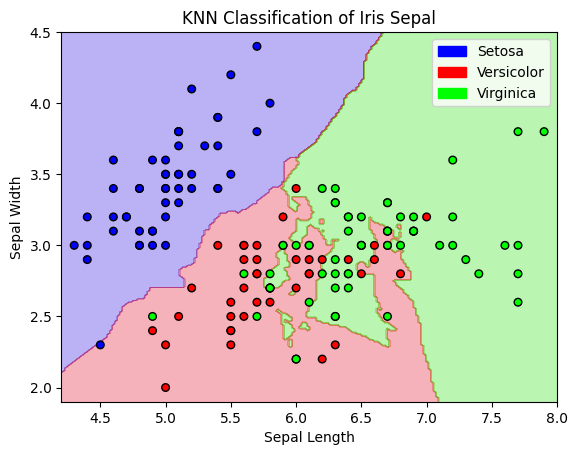

In [42]:
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Using 5 neighbors
knn.fit(X_iris[:, :2], y_iris)

# Create a mesh grid for decision boundary
x_min, x_max = X_iris[:, 0].min() - 0.1, X_iris[:, 0].max() + 0.1
y_min, y_max = X_iris[:, 1].min() - 0.1, X_iris[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict the class for each point in the grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.3, cmap='brg')

# Plot the data points
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap='brg', edgecolor='k', s=30)

# Legend for species
handles = [
    mpatches.Patch(color=plt.get_cmap("brg", 3)(0), label='Setosa'),
    mpatches.Patch(color=plt.get_cmap("brg", 3)(1), label='Versicolor'),
    mpatches.Patch(color=plt.get_cmap("brg", 3)(2), label='Virginica')
]
plt.legend(handles=handles, loc='upper right')

# Labels and title
plt.title("KNN Classification of Iris Sepal")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()

In [44]:
y_pred = knn.predict(X_iris[:, :2])

conf_matrix = confusion_matrix(y_iris, y_pred)

# Compute APER (Apparent Error Rate)
aper = 1 - accuracy_score(y_iris, y_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print("\nApparent Error Rate (APER): {:.4f}".format(aper))

Confusion Matrix:
[[49  1  0]
 [ 0 37 13]
 [ 0 11 39]]

Apparent Error Rate (APER): 0.1667


## Banknotes

In [45]:
from collections import Counter

# Define cost-sensitive priors
c_tf = 10    # Cost of accepting a false banknote
c_ft = 0.05  # Cost of rejecting a true banknote
pf   = 0.001 # Prior probability of a false banknote
pt   = 1 - pf # Prior probability of a true banknote

# Compute adjusted priors
num = c_tf * pf + c_ft * pt  # Normalization factor
p_true_c = (pt * c_ft) / num
p_false_c = (pf * c_tf) / num
prior_c = [p_true_c, p_false_c]

# Ensure labels match the priors
desired_order = ["true", "false"]  # Order must be consistent with priors
banknotes = np.vstack([true_data, false_data])
vf = np.array(["true"]*len(true_data) + ["false"]*len(false_data), dtype=object)
y_encoded = np.array([desired_order.index(label) for label in vf])  # Encode labels


# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(banknotes, y_encoded)

# Retrieve neighbors for each test sample
distances, indices = knn.kneighbors(banknotes)

# Custom decision function that adjusts for priors
y_pred_adjusted = []
for i in range(len(banknotes)):
    neighbors = y_encoded[indices[i]]  # Get nearest neighbors' classes
    vote_counts = Counter(neighbors)  # Count occurrences of each class

    # Adjust votes based on priors
    weighted_votes = {cls: count * prior_c[cls] for cls, count in vote_counts.items()}

    # Assign the class with the highest weighted vote
    adjusted_prediction = max(weighted_votes, key=weighted_votes.get)
    y_pred_adjusted.append(adjusted_prediction)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred_adjusted)


# Print results
print("Confusion Matrix (With Adjusted Priors):")
print(conf_matrix)

Confusion Matrix (With Adjusted Priors):
[[100   0]
 [ 78  22]]


In [46]:
# TODO: compute APER
aper = 1 - accuracy_score(y_encoded, y_pred_adjusted)
aper

0.39

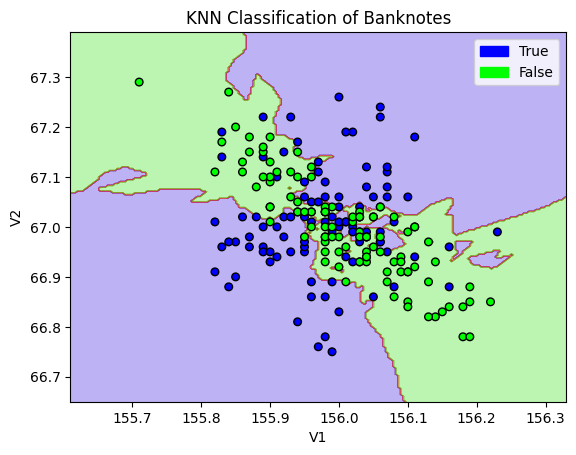

In [47]:
# TODO: plot decision boundaries
# Create a mesh grid for decision boundary
x_min, x_max = banknotes[:, 0].min() - 0.1, banknotes[:, 0].max() + 0.1
y_min, y_max = banknotes[:, 1].min() - 0.1, banknotes[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict the class for each point in the grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.3, cmap='brg')

# Plot the data points
plt.scatter(banknotes[:, 0], banknotes[:, 1], c=y_encoded, cmap='brg', edgecolor='k', s=30)

# Legend for species
handles = [
    mpatches.Patch(color=plt.get_cmap("brg", 2)(0), label='True'),
    mpatches.Patch(color=plt.get_cmap("brg", 2)(1), label='False')
]
plt.legend(handles=handles, loc='upper right')

# Labels and title
plt.title("KNN Classification of Banknotes")
plt.xlabel("V1")
plt.ylabel("V2")
plt.show()